In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


# Import Library

In [2]:
import warnings
warnings.filterwarnings('ignore') #Ignore warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Read and understand data

In [3]:
data=pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Statistical Summary

In [5]:
data.shape

(10000, 14)

In [6]:
data = data.drop(["RowNumber", "CustomerId","Surname"], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# EDA

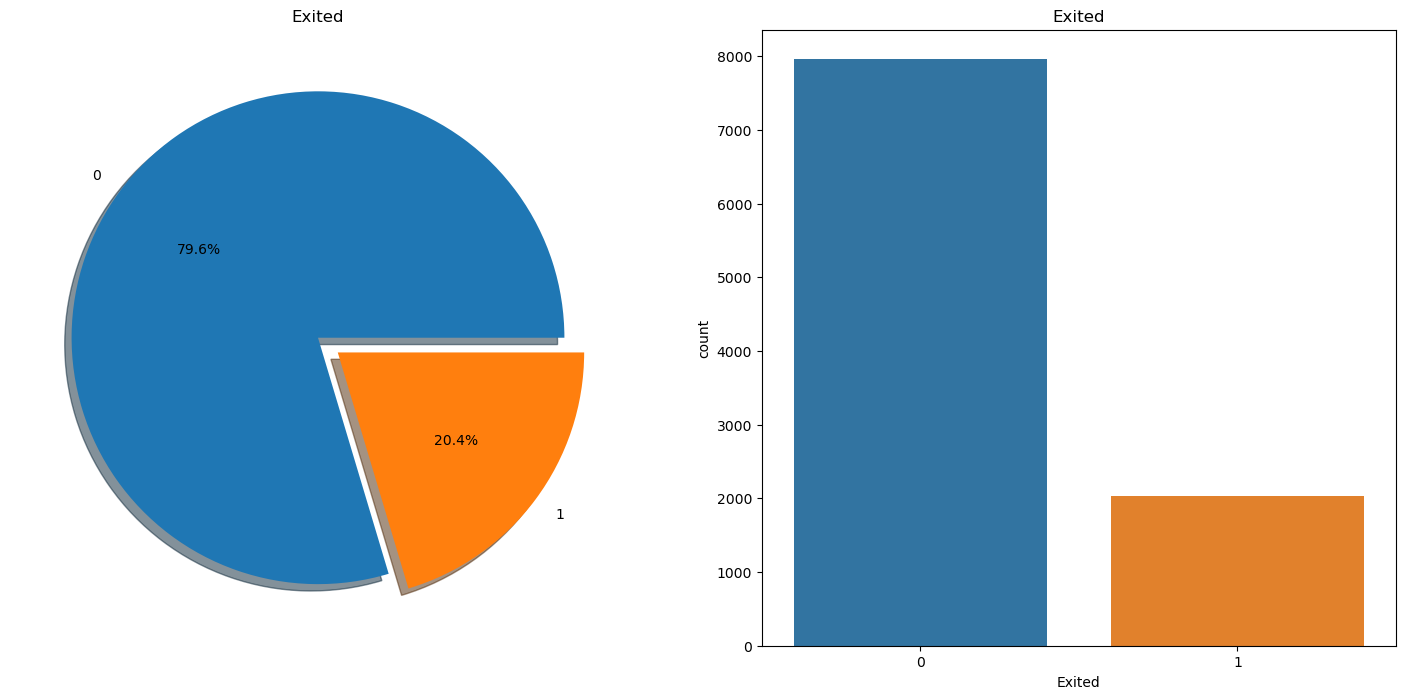

In [11]:

f, ax = plt.subplots(1, 2, figsize=(18, 8))
data['Exited'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Exited')
ax[0].set_ylabel('')

sns.countplot(x='Exited', data=data, ax=ax[1])
ax[1].set_title('Exited')

plt.show()

In [12]:
# Function to create barplots that indicate percentage for each category.
def bar_perc(plot, feature):
    total = len(feature) 
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage

[Text(0.5, 1.0, 'Exited vs Gender')]

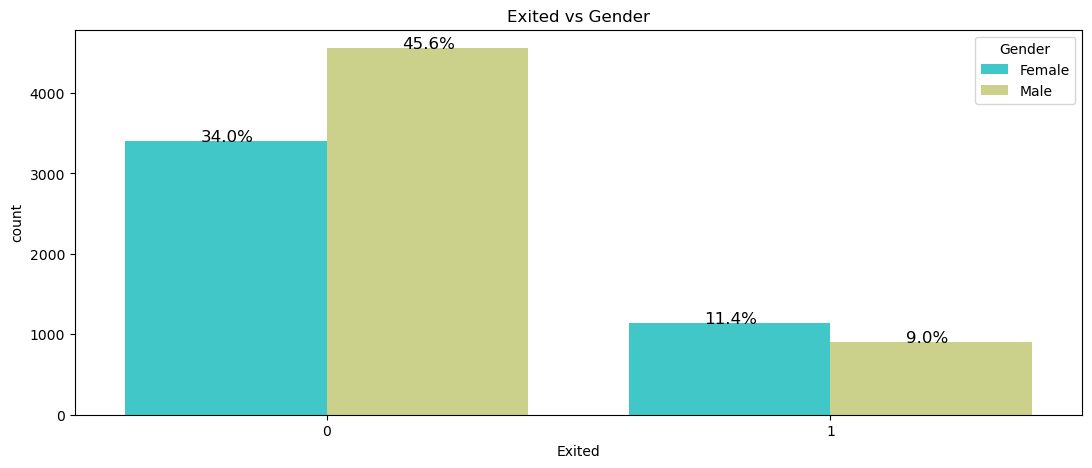

In [13]:
plt.figure(figsize=(13,5))
ax=sns.countplot(x='Exited',hue='Gender',data=data,palette='rainbow')
bar_perc(ax,data['Exited'])
ax.set(title="Exited vs {}".format('Gender'))

In [14]:
country_counts = data.groupby('Geography')['Exited'].sum().reset_index()

In [15]:
country_counts

,Geography,Exited
0,France,810
1,Germany,814
2,Spain,413


In [16]:
import pandas as pd
import folium

# create sample data
# number of customers who exited by country
exit_counts = data[data['Exited'] == 0].groupby('Geography').size()
exit_counts = exit_counts.to_frame().reset_index()
exit_counts.columns = ['country', 'exited']

# number of customers who stayed by country
stay_counts = data[data['Exited'] == 1].groupby('Geography').size()
stay_counts = stay_counts.to_frame().reset_index()
stay_counts.columns = ['country', 'stayed']

# coordinates of each country's center
country_coords = {
    'France': (46.2276, 2.2137),
    'Spain': (40.4637, -3.7492),
    'Germany': (51.1657, 10.4515)
}

# create the map
m = folium.Map(location=[48, 8], zoom_start=4)

# add markers to the map for each country
for country, coords in country_coords.items():
    exit_count = exit_counts[exit_counts['country'] == country]['exited'].values[0]
    stay_count = stay_counts[stay_counts['country'] == country]['stayed'].values[0]
    
    # create the marker's content
    html = f'<b>{country}</b><br><br>Exited: {exit_count}<br>Stayed: {stay_count}'
    
    # create the marker and add it to the map
    folium.Marker(
        location=coords,
        popup=html,
        icon=None
    ).add_to(m)

# display the map
m

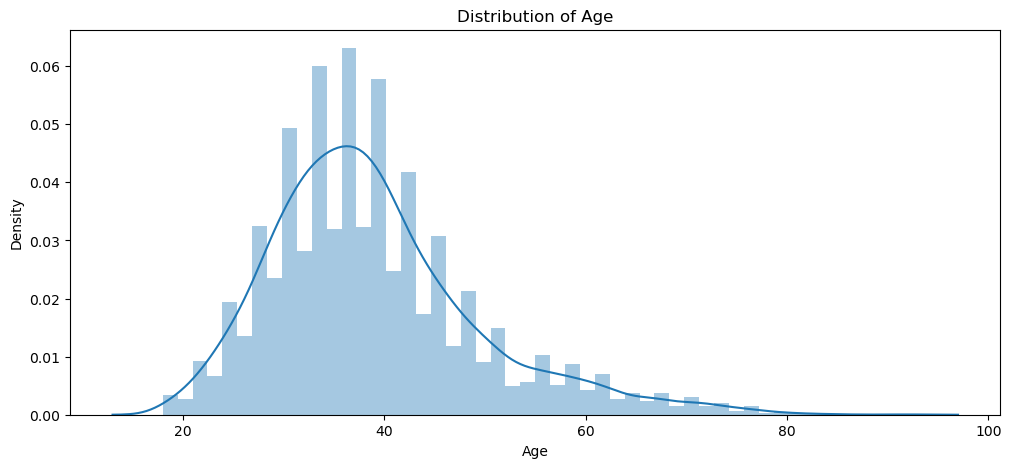

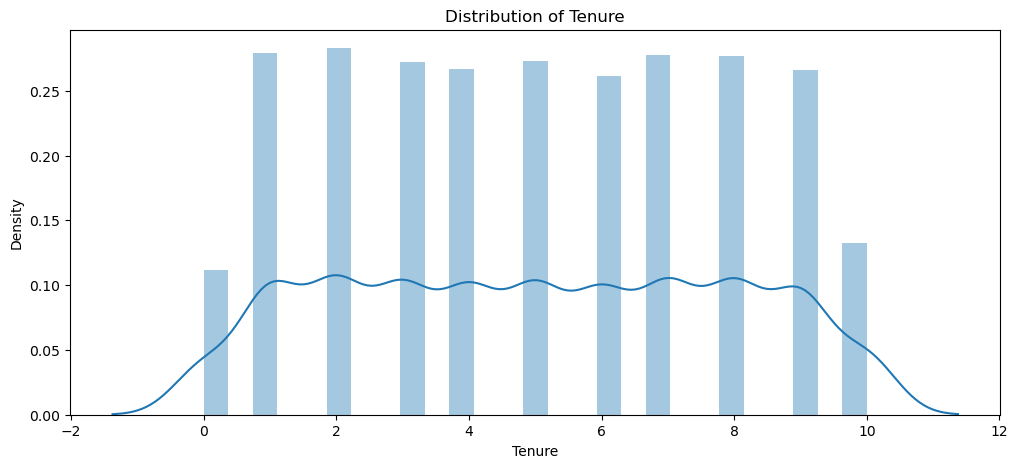

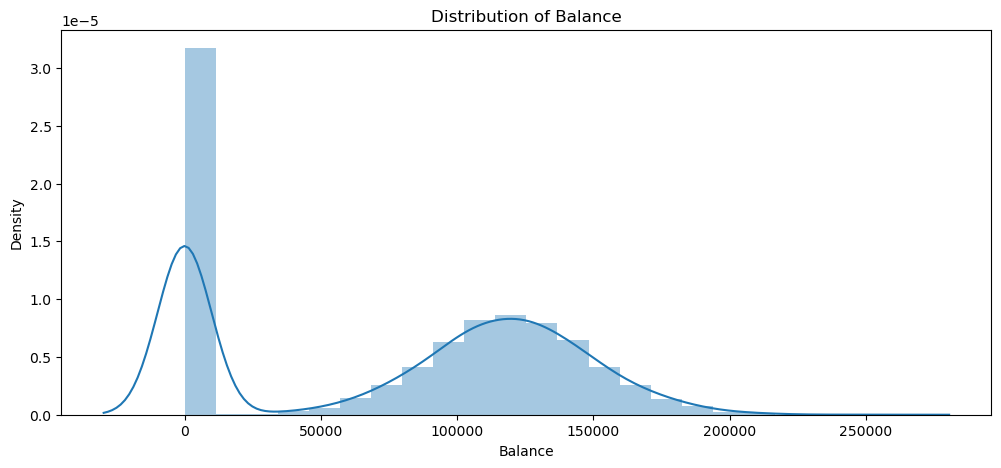

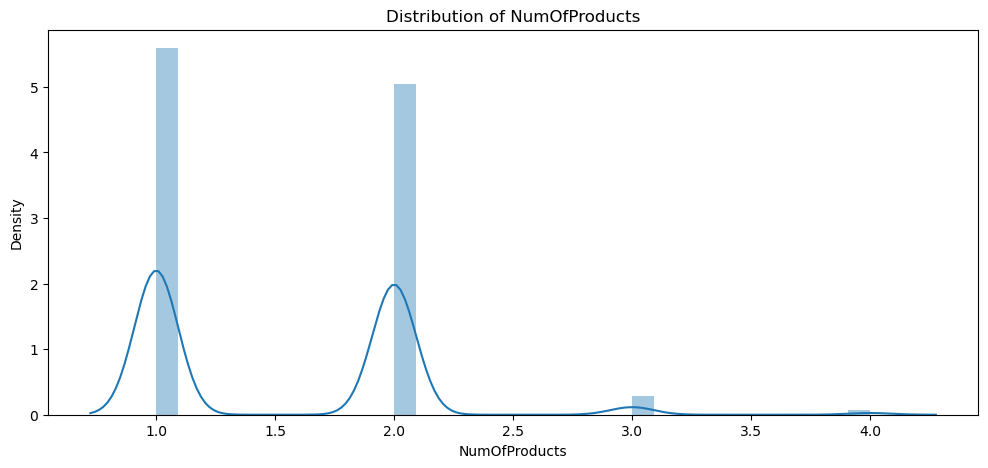

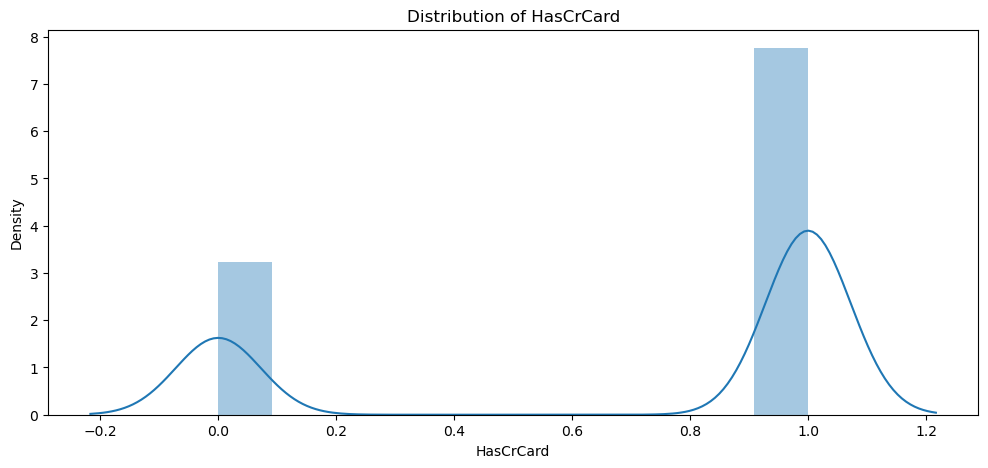

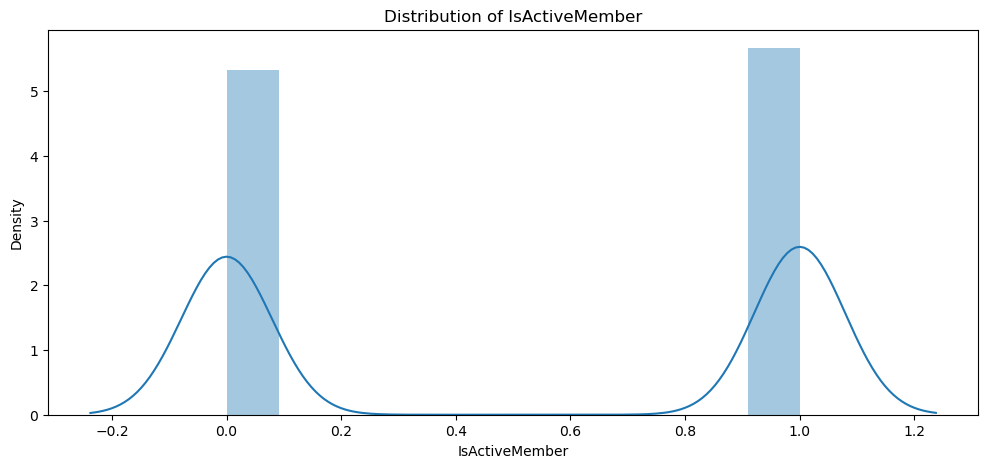

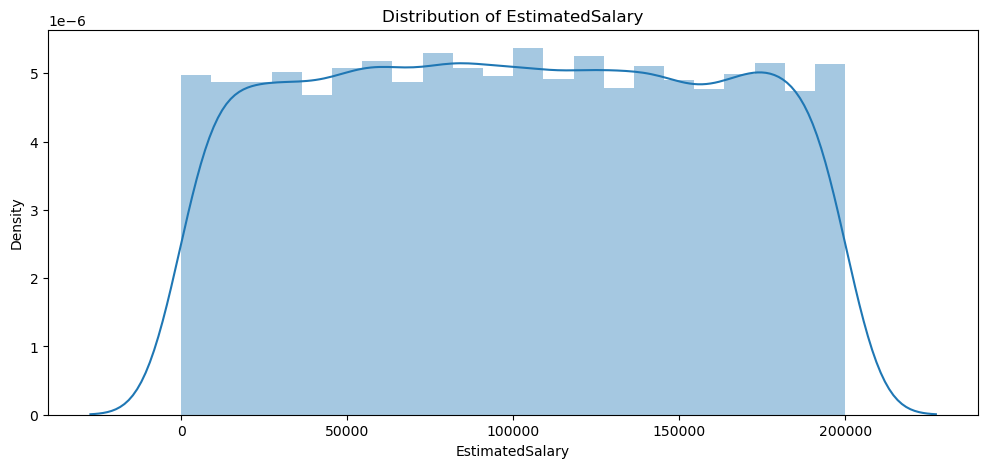

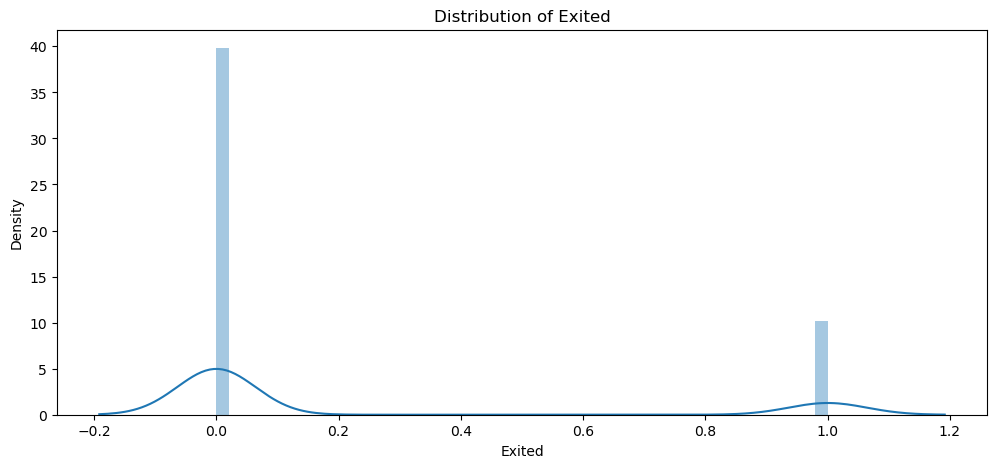

In [17]:
numeric = data.select_dtypes(include = 'number')
for col in list(numeric)[1:]:
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {col}")
    ax = sns.distplot(data[col])
    plt.show()

In [18]:
X = data.drop(["Exited"],axis=1)
y = data.loc[:,'Exited']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [19]:
print(f'X train shape is: {X_train.shape}')
print(f'X test shape is: {X_test.shape}')
print(f'y train shape is: {y_train.shape}')
print(f'y test shape is: {y_test.shape}')

X train shape is: (7000, 10)
X test shape is: (3000, 10)
y train shape is: (7000,)
y test shape is: (3000,)


In [20]:
X_train["Gender"].replace({"Male": 0}, inplace=True)
X_test["Gender"].replace({"Male": 0}, inplace=True)
X_train["Gender"].replace({"Female": 1}, inplace=True)
X_test["Gender"].replace({"Female": 1}, inplace=True)

In [21]:
X_train["Gender"].replace({"Male": 0}, inplace=True)
X_test["Gender"].replace({"Male": 0}, inplace=True)
X_train["Gender"].replace({"Female": 1}, inplace=True)
X_test["Gender"].replace({"Female": 1}, inplace=True)

In [22]:
label_encoder = LabelEncoder()
X_train["Geography"] = label_encoder.fit_transform(X_train["Geography"])
X_test["Geography"] = label_encoder.transform(X_test["Geography"])

In [23]:
X_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9069,619,2,1,32,4,175406.13,2,1,1,172792.43
2603,643,1,1,34,7,160426.07,1,0,1,188533.11
7738,561,0,0,33,6,0.00,2,0,0,173680.39
1579,618,1,0,41,8,37702.79,1,1,1,195775.48
5058,714,0,0,37,9,148466.93,2,0,1,151280.96
...,...,...,...,...,...,...,...,...,...,...
5734,768,0,0,54,8,69712.74,1,1,1,69381.05
5191,682,0,1,58,1,0.00,1,1,1,706.50
5390,735,0,1,38,1,0.00,3,0,0,92220.12
860,667,0,0,43,8,190227.46,1,1,0,97508.04


<Figure size 2000x2000 with 0 Axes>

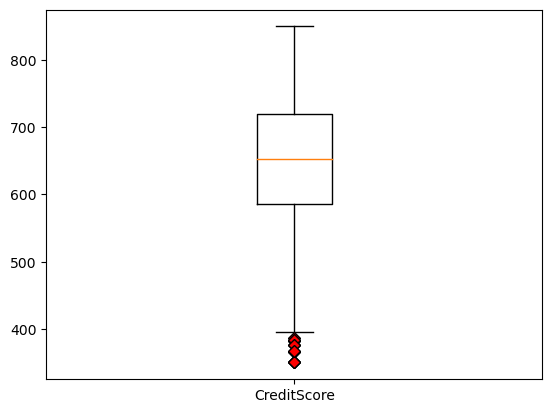

<Figure size 2000x2000 with 0 Axes>

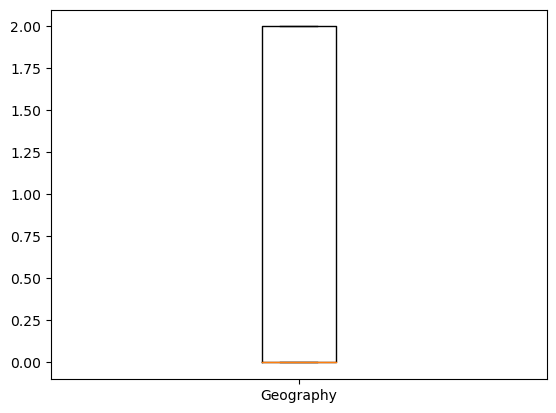

<Figure size 2000x2000 with 0 Axes>

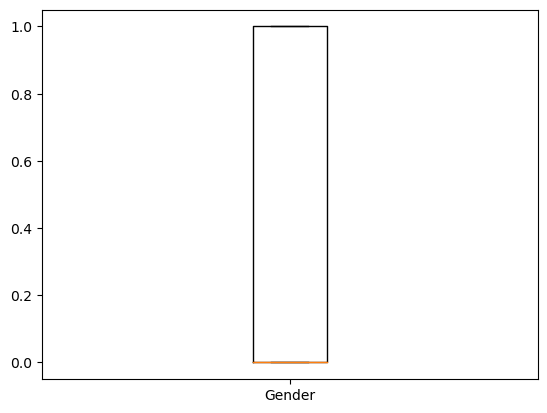

<Figure size 2000x2000 with 0 Axes>

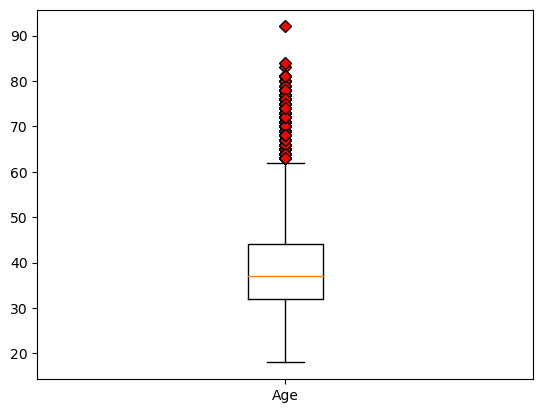

<Figure size 2000x2000 with 0 Axes>

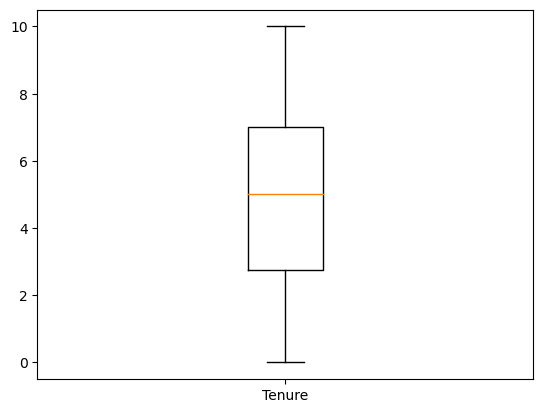

<Figure size 2000x2000 with 0 Axes>

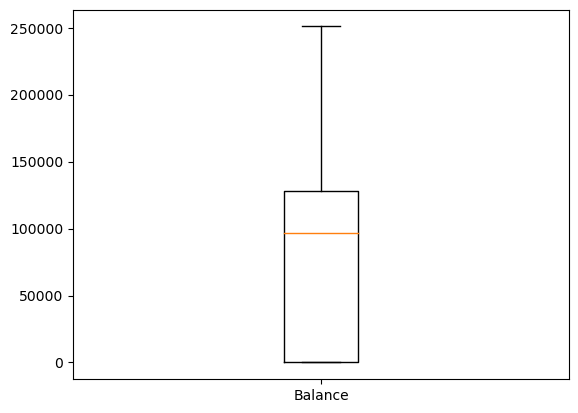

<Figure size 2000x2000 with 0 Axes>

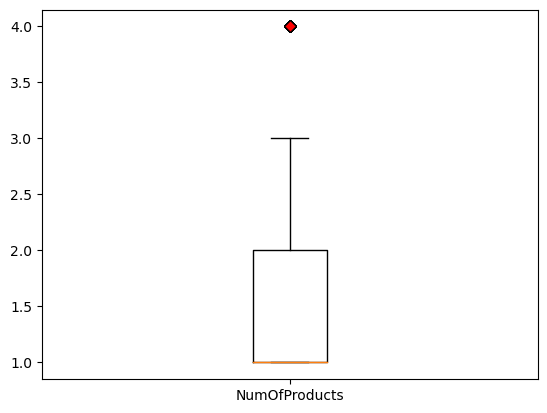

<Figure size 2000x2000 with 0 Axes>

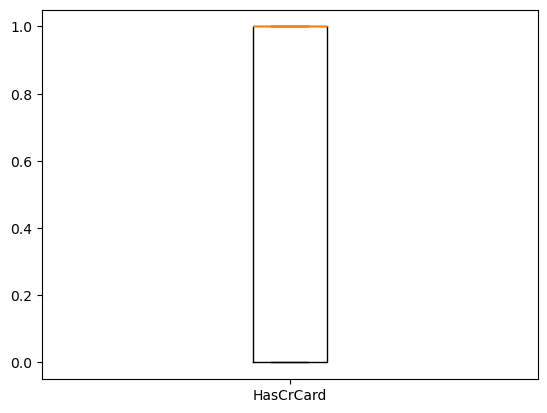

<Figure size 2000x2000 with 0 Axes>

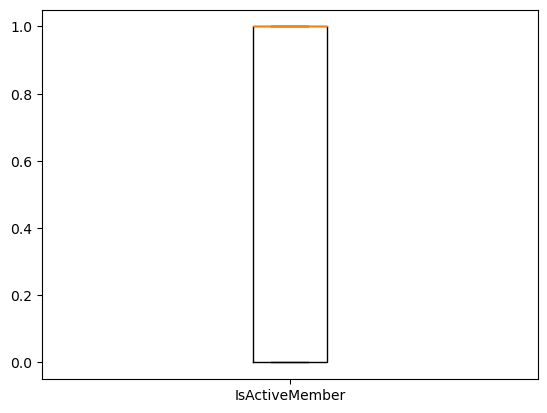

<Figure size 2000x2000 with 0 Axes>

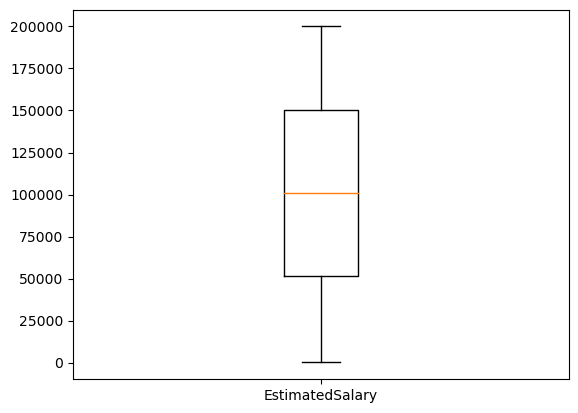

In [24]:
for i in X_train:
 plt.figure(figsize=(20, 20))
 fig, ax = plt.subplots()
 red_diamond = dict(markerfacecolor='r', marker='D')
 plt.boxplot(X_train[i].values, labels=[i], flierprops=red_diamond);
 plt.show()

In [25]:
train_corr  = X_train.corr(method='pearson').abs()
train_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.00,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.02,0.00
Geography,0.01,1.00,0.01,0.02,0.01,0.06,0.01,0.01,0.01,0.00
Gender,0.01,0.01,1.00,0.04,0.02,0.01,0.02,0.00,0.02,0.01
Age,0.01,0.02,0.04,1.00,0.01,0.03,0.05,0.03,0.08,0.00
Tenure,0.01,0.01,0.02,0.01,1.00,0.01,0.01,0.02,0.02,0.02
Balance,0.01,0.06,0.01,0.03,0.01,1.00,0.30,0.02,0.02,0.01
NumOfProducts,0.02,0.01,0.02,0.05,0.01,0.30,1.00,0.01,0.03,0.01
HasCrCard,0.00,0.01,0.00,0.03,0.02,0.02,0.01,1.00,0.01,0.02
IsActiveMember,0.02,0.01,0.02,0.08,0.02,0.02,0.03,0.01,1.00,0.01
EstimatedSalary,0.00,0.00,0.01,0.00,0.02,0.01,0.01,0.02,0.01,1.00


# PIPELINE

In [26]:
pipeline_logistic=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LogisticRegression())])

pipeline_decision_t=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeClassifier())])


pipeline_random_f=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestClassifier())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("kn_classifier",KNeighborsClassifier())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("xg_classifier",XGBClassifier())])


pipeline_svm=Pipeline([("scalar5",StandardScaler()),
                     ("svm_classifier",SVC())])
pipelines = [pipeline_logistic, pipeline_decision_t, pipeline_random_f, pipeline_kn, pipeline_xgb,pipeline_svm]
pipe_dict = {0: "LogisticRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGB",5 : "SCV"}
for pipe in pipelines:
    pipe.fit(X_train, y_train)
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="f1", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LogisticRegression: 0.276979 
DecisionTree: 0.493650 
RandomForest: 0.567501 
KNeighbors: 0.469639 
XGB: 0.565103 
SCV: 0.515061 


In [27]:
pipelines = [pipeline_logistic, pipeline_decision_t, pipeline_random_f, pipeline_kn, pipeline_xgb,pipeline_svm]
for i in pipelines:
  print(i[1],"--  ",round(i.score(X_test, y_test),2)*100,"%")

LogisticRegression() --   82.0 %
DecisionTreeClassifier() --   80.0 %
RandomForestClassifier() --   87.0 %
KNeighborsClassifier() --   84.0 %
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) --   87.0 %
SVC() --   86.0 %


In [28]:
model = RandomForestClassifier()

In [29]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [30]:
y_pred=model.predict(X_test)

In [31]:

model.score(X_test,y_test)

0.8696666666666667

In [32]:
model.score(X_train,y_train)

1.0

# Adversarial Validation

In [33]:
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = xgb.cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

2    0.509993
Name: test-auc-mean, dtype: float64


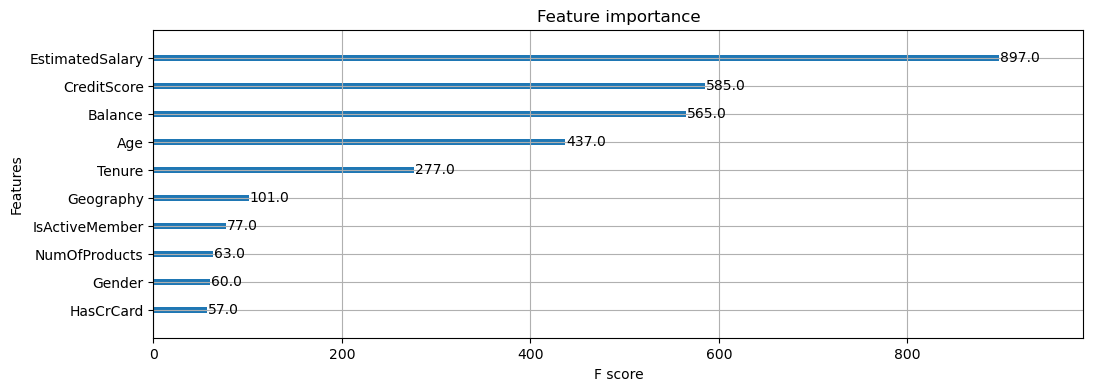

In [34]:
from xgboost import plot_importance
classifier_over = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier_over.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier_over, ax=ax)
plt.show();

In [35]:
cf_matrix = confusion_matrix(y_test,y_pred)

In [36]:
cf_matrix

array([[2340,   76],
       [ 315,  269]])

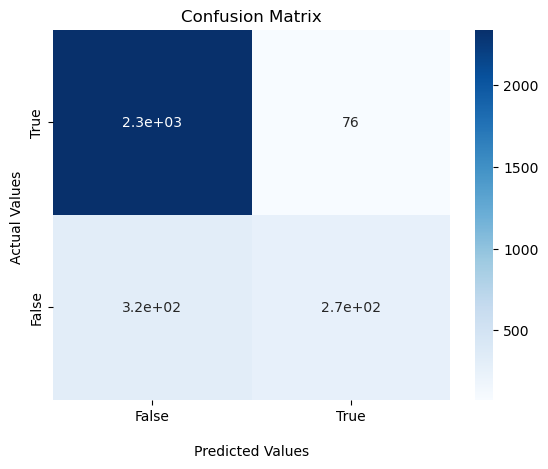

In [37]:
con = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
con.set_title('Confusion Matrix');
con.set_xlabel('\nPredicted Values')
con.set_ylabel('Actual Values ');
con.xaxis.set_ticklabels(['False','True'])
con.yaxis.set_ticklabels(['True','False'])
plt.show()

In [38]:
data = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predicted Positive', 'Predicted Negative'], 
                  index=['Actual Positive', 'Actual Negative'])
data

,Predicted Positive,Predicted Negative
Actual Positive,2340,76
Actual Negative,315,269


In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.46      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.71      0.75      3000
weighted avg       0.86      0.87      0.86      3000

